In [14]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.constants import e, h, hbar, pi
from scipy.linalg import solve_sylvester
from two_coupled_qubits import ChargeQubit, Resonator
from IPython.display import display, Math

def comm(a, b):
    return a@b - b@a

def reduce_matrix(matrix, dim):
    reduced_matrix = np.zeros((4, 4), dtype=complex)

    reduced_matrix[0, 0] = matrix[0, 0]
    reduced_matrix[0, 1] = matrix[0, dim]
    reduced_matrix[0, 2] = matrix[0, dim**2]
    reduced_matrix[0, 3] = matrix[0, dim**2 + dim]
    reduced_matrix[1, 0] = matrix[dim, 0]
    reduced_matrix[1, 1] = matrix[dim, dim]
    reduced_matrix[1, 2] = matrix[dim, dim**2]
    reduced_matrix[1, 3] = matrix[dim, dim**2 + dim]
    reduced_matrix[2, 0] = matrix[dim**2, 0]
    reduced_matrix[2, 1] = matrix[dim**2, dim]
    reduced_matrix[2, 2] = matrix[dim**2, dim**2]
    reduced_matrix[2, 3] = matrix[dim**2, dim**2 + dim]
    reduced_matrix[3, 0] = matrix[dim**2 + dim, 0]
    reduced_matrix[3, 1] = matrix[dim**2 + dim, dim]
    reduced_matrix[3, 2] = matrix[dim**2 + dim, dim**2]
    reduced_matrix[3, 3] = matrix[dim**2 + dim, dim**2 + dim]
    
    return Qobj(reduced_matrix)

In [15]:
# Qubit and Resonator Qobj
q1 = ChargeQubit(e_c=0.23084, e_j=16.34, levels=4, n_g=0)
q2 = ChargeQubit(e_c=0.23084, e_j=16.34, levels=4, n_g=0)
r = Resonator(dim=9, w=(2 * pi) * 7.50, c_r=368.440)

# Parameters
c_g1 = 20
c_g2 = 20
beta_1 = c_g1 / (c_g1 + q1.c_s)
beta_2 = c_g2 / (c_g2 + q2.c_s)
g_tr1 = 2 * beta_1 * e * r.v_rms / hbar * 1e-9
g_tr2 = 2 * beta_2 * e * r.v_rms / hbar * 1e-9

display(Math(f"\\omega_{{\\text{{q1}}}}/(2\\pi) = {round(q1.w / (2 * pi),4)} \\text{{ GHz}}"))
display(Math(f"\\omega_{{\\text{{q2}}}}/(2\\pi) = {round(q2.w / (2 * pi),4)} \\text{{ GHz}}"))
display(Math(f"\\omega_{{\\text{{r}}}}/(2\\pi) = {round(r.w / (2 * pi),4)} \\text{{ GHz}}"))
display(Math(f"g_{{\\text{{tr1}}}}/(2\\pi) = {round(g_tr1 / (2 * pi),4)} \\text{{ GHz}}"))
display(Math(f"g_{{\\text{{tr2}}}}/(2\\pi) = {round(g_tr2 / (2 * pi),4)} \\text{{ GHz}}"))
display(Math(f"\\alpha_1/(2\\pi) = {round(-q1.e_c,4)} \\text{{ GHz}}"))
display(Math(f"\\alpha_2/(2\\pi) = {round(-q2.e_c,4)} \\text{{ GHz}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
# Operators
b = destroy(r.dim)

# Diagonalize the qubits Hamiltonian
eigenvalues, eigenvectors = q1.h.eigenstates()
q1_h = Qobj(np.diag(eigenvalues))
eigenvalues, eigenvectors = q2.h.eigenstates()
q2_h = Qobj(np.diag(eigenvalues))

# Free Hamiltonian
h0 = tensor(q1_h, qeye(q1.dim), qeye(r.dim)) + \
     tensor(qeye(q1.dim), q2_h, qeye(r.dim)) + \
     tensor(qeye(q1.dim), qeye(q2.dim), r.h)

# Interacting Hamiltonian
hint = tensor(g_tr1 * q1.number[1],  qeye(q2.dim), - 1j * (b - b.dag())) + \
       tensor(qeye(q1.dim),  g_tr2 * q2.number[1], - 1j * (b - b.dag()))

# S matrix
s = Qobj(solve_sylvester(-h0.full(), h0.full(), -hint.full()))

# Effective Interacting Hamiltonian
hint_eff = 1/2 * (comm(s.full(),hint.full())) + \
           1/3 * (comm(s.full(),comm(s.full(),hint.full())))

In [17]:
# Projecting on computational basis
h0_red = reduce_matrix(h0, q1.dim)
hint_eff_red = reduce_matrix(hint_eff, q1.dim)
h_red = Qobj(h0_red.full() + hint_eff_red.full())

# States |00>, |01>, |10>, |11>
_, eigenvectors = h0_red.eigenstates()
psi00 = eigenvectors[0]
psi01 = eigenvectors[1]
psi10 = eigenvectors[2]
psi11 = eigenvectors[3]

t_list = np.linspace(0, 20, 10000)

# Master Equation
result = mesolve(H=h_red, rho0=psi10, tlist=t_list, c_ops=[], e_ops=[], args={})
prob00 = expect(psi00*psi00.dag(), result.states)
prob01 = expect(psi01*psi01.dag(), result.states)
prob10 = expect(psi10*psi10.dag(), result.states)
prob11 = expect(psi11*psi11.dag(), result.states)

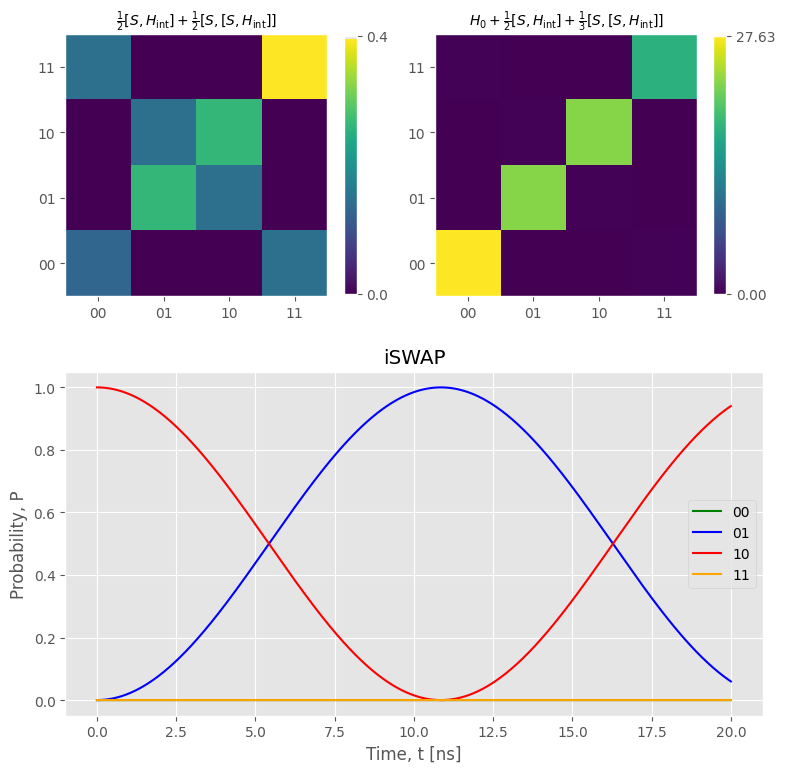

In [18]:
plt.style.use("ggplot")

plt.figure(figsize=(8, 8))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 1, 2)

ax1.set_aspect("equal")
cm = ax1.pcolormesh(range(4), range(4), np.abs(hint_eff_red.full()), cmap="viridis")
cbar = plt.colorbar(cm, ax=ax1, shrink=0.75)
ax1.set_title("$\\frac{1}{2} [S, H_\\text{int}] + \\frac{1}{2} [S,[S,H_\\text{int}]]$", fontsize=10)
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(["00", "01", "10", "11"])
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(["00", "01", "10", "11"])
cbar.set_ticks(
    [
        round(np.min(np.abs(hint_eff_red.full())), 2),
        round(np.max(np.abs(hint_eff_red.full())), 2),
    ]
)


ax2.set_aspect("equal")
cm = ax2.pcolormesh(range(4), range(4), np.abs(h_red.full()), cmap="viridis")
cbar = plt.colorbar(cm, ax=ax2, shrink=0.75)
ax2.set_title("$H_0 + \\frac{1}{2}[S, H_\\text{int}] + \\frac{1}{3}[S,[S,H_\\text{int}]]$", fontsize=10)
ax2.set_xticks([0, 1, 2, 3])
ax2.set_xticklabels(["00", "01", "10", "11"])
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(["00", "01", "10", "11"])
cbar.set_ticks(
    [round(np.min(np.abs(h_red.full())), 2), round(np.max(np.abs(h_red.full())), 2)]
)


ax3.plot(t_list, prob00, label="00", color="green")
ax3.plot(t_list, prob01, label="01", color="blue")
ax3.plot(t_list, prob10, label="10", color="red")
ax3.plot(t_list, prob11, label="11", color="orange")
ax3.set_title("iSWAP")
ax3.set_xlabel("Time, t [ns]")
ax3.set_ylabel("Probability, P")
ax3.legend()

plt.tight_layout()
plt.show()


In [19]:
def pauli_sym(idx: int) -> str:
    names = ["I", "X", "Y", "Z"]
    return names[idx]

pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
terms = []

for idx1, matrix1 in enumerate(pauli):
    for idx2, matrix2 in enumerate(pauli):
        value = 1/4 * np.trace(tensor(matrix1, matrix2).full()@h_red.full())
        if np.abs(value) > 1e-10:
            term = f"{np.round(value,3)}\\mathbb{{{pauli_sym(idx1)}}}\\mathbb{{{pauli_sym(idx2)}}}"
            terms.append(term)

expansion = " + ".join(terms)
display(Math(f'H_{{\\text{{eff}}}} = {expansion}'))

value = 1/4 * np.trace(tensor(sigmaz(), sigmaz()).full()@h_red.full())
display(Math(f'\\zeta = {value}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
h0

Quantum object: dims = [[13, 13, 13], [13, 13, 13]], shape = (2197, 2197), type = oper, isherm = True
Qobj data =
[[-27.51033398   0.           0.         ...   0.           0.
    0.        ]
 [  0.          19.61355582   0.         ...   0.           0.
    0.        ]
 [  0.           0.          66.73744562 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 543.98239498   0.
    0.        ]
 [  0.           0.           0.         ...   0.         591.10628478
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  638.23017459]]

In [8]:
tensor(sigmaz(),sigmaz())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]

In [7]:
np.trace(h_red.full())

(-90.90827489923332+0j)

In [10]:
def pauli_sym(idx: int) -> str:
    names = ["I", "X", "Y", "Z"]
    return names[idx]

pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
terms = []

for idx1, matrix1 in enumerate(pauli):
    for idx2, matrix2 in enumerate(pauli):
        value = 1/4 * np.trace(tensor(matrix1, matrix2).full()@h_red.full())
        if np.abs(value) > 1e-10:
            term = f"{np.round(value,3)}\\mathbb{{{pauli_sym(idx1)}}}\\mathbb{{{pauli_sym(idx2)}}}"
            terms.append(term)

expansion = " + ".join(terms)
display(Math(f'H_{{\\text{{eff}}}} = {expansion}'))

value = 1/4 * np.trace(tensor(sigmaz(), sigmaz()).full()@h_red.full())
display(Math(f'\\zeta = {value}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>